### Single-GPU benchmarks of different multiple RHS (mRHS) 9-point stencil kernels/routines
We benchmark the performance of two different approaches to a 9-point multiple rhs matrix-vector stencil.
Namely, we compare the cuBLAS approach of calling `gemmBatched` once for every point vs writing the stencil kernel from scratch in CUDA.
The second approach allows for reduced copy operations and improved cache usage at the cost of managing low-level CUDA code.

### Setup
The setup is a set of lattices (several matrix and vector fields) on a 4D Grid (here `8.8.8.8`).
The matrices have `N x N` shape, the vectors subsequently are of size `N`.
We test the values `N = 32, 64`.
The number of right hand sizes is given by `M = 8, 16, 24, 32, 40, 48, 56, 64`. 
Each kernel is run 100 times and the average of the faster 50% of the runs is shown.

The total runtime is split into:
- malloc/exchange: This is the duration for the halo exchange and cell padding.  
- g to b: Memory layout change for compatibility with blas routines.  
- mul: The core operation, i.e., the actual stencil calculation.
- b to g: Memory layout change back to Grid-style
- pMap: Creation of pointer maps for the cuBLAS routines

### Kernels

#### gridBlas
This is the Grid (paboyle) implementation and serves as baseline (commit-hash: 557fa483).
It should be noted that Grid/algorithms/multigrid/GeneralCoarsenedMatrixMultiRHS.h has been modified to work with ComplexF, rather than being hardcoded to ComplexD.

#### blas
This kernel uses the cuBLAS library.
Since there is no native mRHS matrix-vector call, we use the `gemmStridedBatched` and `gemmBatched` routine.
These routines perform matrix-matrix mul on a batch of matrices, the first one additionally assumes a fixed stride between memory locations of the matrices, hence `Strided`. 
Initially, the set of vector fields are transform to a single matrix field (see plots: `cp-in`, orange).
Additionally, the data of a matrix must be contiguous in memory, so a Grid-style memory layout requires extra transformation work.
After the transformation the cuBLAS kernel can be called (see plots: `op`, green).
Finally, the resulting matrix field must be transformed back into a set of vector field (see plots: `cp-out`, red).

Notes:
The cublas routines are unbeatably performant at normal matrix-matrix multiplication but they do not exploit the fact that the vectors can be kept in shmem (user managed cache) for all nine points of the stencil. 

Remarks on my benchmark:
The primary goal of the cuBLAS approach was to reconstruct the performance characteristics of Grid.
This mostly worked.
However, for `M = 8, 16` the performance is significantly worse than Grid.
My cuBLAS approach requires a `cudaDeviceSynchronize()` call after every point calculation (i.e., 9 times) due to the pointer map being saved in a single buffer.
Grid requires only one synchronization call.
This is a rough oversight.
Removing the first 8 synchronization calls reproduces the Grid performance for low `M`, but leads to wrong results, of course.


#### 2dbtv2
This is a custom cuda kernel implementation and exploits the fact, that the batch of vectors can be kept in shmem for all nine stencil points.
Additionally no copy-in or copy-out is required as the transformation is made during the copy into the shmem.
Only one kernel call is issued to the GPU scheduler.
The performance is good throughout the parameter space.
The following fine-grained optimisations for matmul from the shared memory level downwards to register level have been used:
- shmem for user-managed caching
- gmem coalescing/vectorization (open to further optimization)
- memory bank conflict avoidance / transfer action optimisation
- shmem load broadcasting
- shmem load vectorization
- manual register "caching"

For npoints -> inf the performance factor over the blas solution converges to 1 + 2*M/N

### Notes on the exchange term
The halo exchange takes a significant amount of time. 
The 2dbtv2 kernel would allow for splitting into bulk/halo computations and therefore latency hiding of the exchange.
This offers further optimisation.


Found 1600 measurements


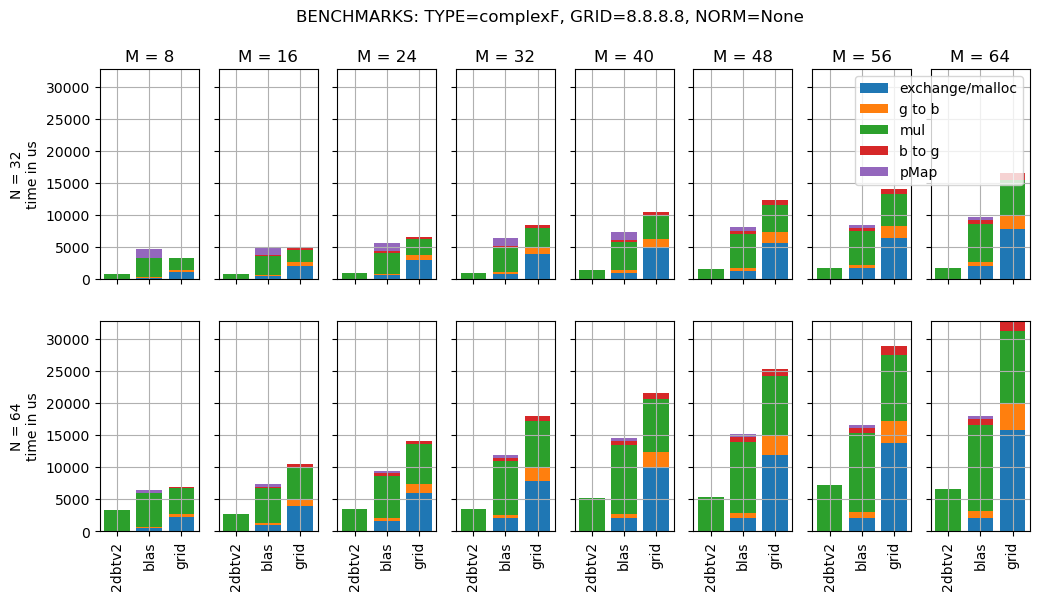

In [1]:
import os
os.chdir(os.getenv("HOME") + "/phd/cuda_grid/runs/nine_point_stencil")
import pyBench

data = pyBench.loadBlas()
data.update(pyBench.loadGrid())
data.update(pyBench.load2dbtv2())
plotter = pyBench.Plotter(data)
plotter.reduce()
plotter.plot_fixed_grid()
# plotter.plot_fixed_grid(normalization="bandwidth")
# plotter.plot_fixed_grid(normalization="flops")